## Elevation Data Acquisition & Preprocess

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
crs = {'init': 'epsg:4326'}

#### Open the full climatology dataset

In [2]:
df = pd.read_csv('Full_Climatology.csv')
del df['Unnamed: 0']
gdf = gpd.GeoDataFrame(df, crs=crs, geometry = gpd.points_from_xy(df.Longitude, df.Latitude))
del df

In [3]:
#it is a huge data set with more than 1.5 million datapoints
#filter the gdf and keep only the entries with frd > 5
gdf = gdf[gdf.VHRFC_LIS_FRD > 5]
gdf

,Latitude,Longitude,VHRFC_LIS_FRD,geometry
25,-37.95,-143.25,11.821247,POINT (-143.25000 -37.95000)
64,-37.95,-70.25,10.962107,POINT (-70.25000 -37.95000)
102,-37.95,-64.85,5.436871,POINT (-64.85000 -37.95000)
104,-37.95,-64.65,5.594469,POINT (-64.65000 -37.95000)
113,-37.95,-63.65,6.793575,POINT (-63.65000 -37.95000)
...,...,...,...,...
1515491,37.95,131.75,5.861458,POINT (131.75000 37.95000)
1515502,37.95,136.25,5.857105,POINT (136.25000 37.95000)
1515515,37.95,139.35,7.016274,POINT (139.35000 37.95000)
1515563,37.95,154.25,5.855022,POINT (154.25000 37.95000)


#### Connect to Google Engine and extract elevation

In [4]:
import ee
print(ee.__version__)

0.1.216


In [5]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1wFqg6G0jEvC72WYYBBjdKqG9iBuP5LdMOQUKd7AqAIBRlA3NOkATHU

Successfully saved authorization token.


In [ ]:
%%time
dem = ee.Image('USGS/SRTMGL1_003')

#get a copy of the geodatafame and add an empty column for the elevation
gdf_c = gdf.copy()
gdf_c['elevation'] = ""

#for some coordinates there is no elevation info: bypass these rows and continue to the next set of coordinates
#add each elevation to the corresponding place in the geodataframe
for x,y,i in zip(gdf_c.Longitude, gdf_c.Latitude, range(gdf_c.shape[0])):
    point = ee.Geometry.Point([x, y])
    try:
        gdf_c['elevation'].iloc[i] = dem.sample(point, 30).first().get('elevation').getInfo()
    except:
        continue

gdf_nan = gdf_c.replace('', np.nan)

missed data for elevation: 53483 datapoints, 10.7% of the data


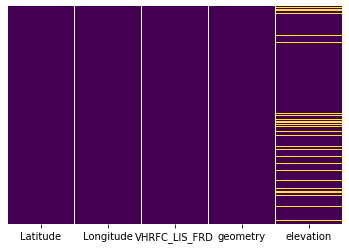

In [9]:
#check for missing elevation data (from originally missing values)= NaN

import seaborn as sns
sns_plot = sns.heatmap(gdf_nan.isna(),yticklabels=False,cbar=False, cmap='viridis')

fig = sns_plot.get_figure()

fig.savefig('missing_values.png')

print("missed data for elevation: {} datapoints, {}% of the data".format(gdf[gdf.elevation.isna()].shape[0], round(gdf[gdf.elevation.isna()].shape[0] / gdf.shape[0] *100,1)))

In [10]:
gdf_clean = gdf_nan.dropna()

gdf_clean.to_csv('elevation_gdf.csv')

In [11]:
gdf_clean

,Latitude,Longitude,VHRFC_LIS_FRD,geometry,elevation
1,-37.95,-70.25,10.962107,POINT (-70.25000 -37.95000),1131.0
2,-37.95,-64.85,5.436871,POINT (-64.85000 -37.95000),240.0
3,-37.95,-64.65,5.594469,POINT (-64.65000 -37.95000),210.0
4,-37.95,-63.65,6.793575,POINT (-63.65000 -37.95000),166.0
5,-37.95,-63.35,9.180014,POINT (-63.35000 -37.95000),211.0
...,...,...,...,...,...
500995,37.95,126.75,6.424875,POINT (126.75000 37.95000),107.0
500996,37.95,127.65,5.036127,POINT (127.65000 37.95000),399.0
500997,37.95,131.75,5.861458,POINT (131.75000 37.95000),0.0
500998,37.95,136.25,5.857105,POINT (136.25000 37.95000),0.0


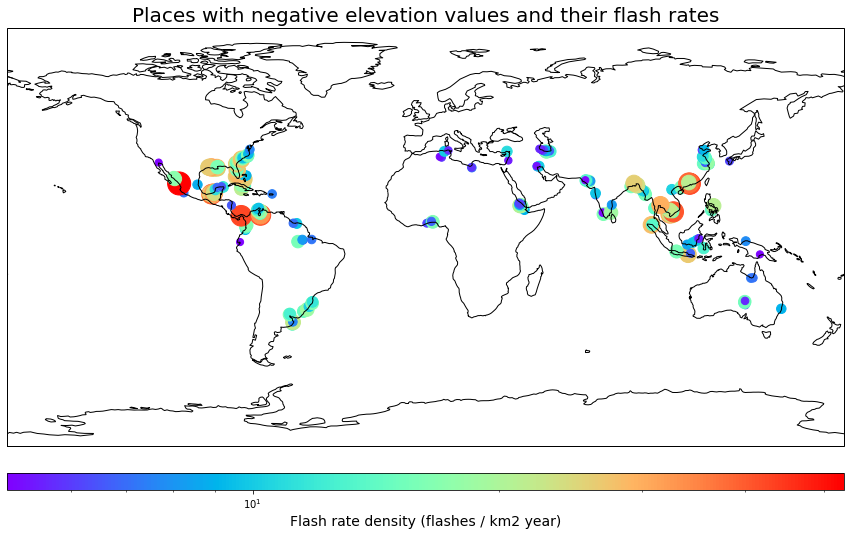

In [12]:
#check the negative elevation values
gdf_neg = gdf_clean[gdf_clean.elevation < 0]

from matplotlib.colors import LogNorm
plt.close('all')

f = plt.figure(figsize=(15,10)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180,-90, 90])
ax.coastlines()

img = ax.scatter(gdf_neg.Longitude, gdf_neg.Latitude, s=gdf_neg.VHRFC_LIS_FRD*10, c=gdf_neg.VHRFC_LIS_FRD, cmap=plt.cm.rainbow, norm=LogNorm())
ax.set_title('Places with negative elevation values and their flash rates', fontsize=20)
cb = plt.colorbar(img, orientation='horizontal', pad=0.05, aspect = 50) 
cb.set_label('Flash rate density (flashes / km2 year)', fontsize=14) 

plt.savefig('Map with negative elevation.png', bbox_inches='tight')

plt.show()

In [13]:
gdf_neg.sort_values(by='elevation')

,Latitude,Longitude,VHRFC_LIS_FRD,geometry,elevation
467458,32.85,35.55,5.396693,POINT (35.55000 32.85000),-216.0
325696,11.65,42.45,9.109092,POINT (42.45000 11.65000),-154.0
348462,14.15,40.35,5.448632,POINT (40.35000 14.15000),-120.0
349312,14.25,40.25,7.659740,POINT (40.25000 14.25000),-120.0
347622,14.05,40.45,5.580790,POINT (40.45000 14.05000),-119.0
...,...,...,...,...,...
309234,9.95,105.85,11.509728,POINT (105.85000 9.95000),-1.0
412625,24.35,68.65,5.121790,POINT (68.65000 24.35000),-1.0
413664,24.55,-107.65,6.666922,POINT (-107.65000 24.55000),-1.0
318370,10.95,-71.35,6.312249,POINT (-71.35000 10.95000),-1.0
